**EXAMEN FINAL PREGUNTA 2**

* Dataset:https://drive.google.com/drive/folders/1G3ZumR0DDARyRQL4JadeCwvCOIZBDKSr?usp=sharing
* repositorio github:https://github.com/R1mber/sis421/tree/master/Examenes/final

```

Pregunta numero 2


In [36]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [39]:
#!cp -av "/content/drive/MyDrive/dataset_basura_deteccion" "/content/data"

In [4]:
image_id=1
coco_data=COCO("/content/data/labels/cartones/polygon/labels_cartones_coco_format.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [5]:
img = coco_data.imgs[image_id]
img

{'file_name': 'carton (51).png', 'height': 600, 'id': 1, 'width': 800}

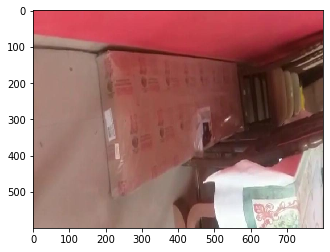

In [6]:
image = np.array(Image.open("/content/data/images/cartones/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

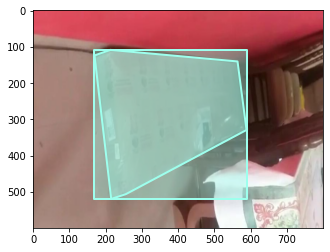

In [7]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

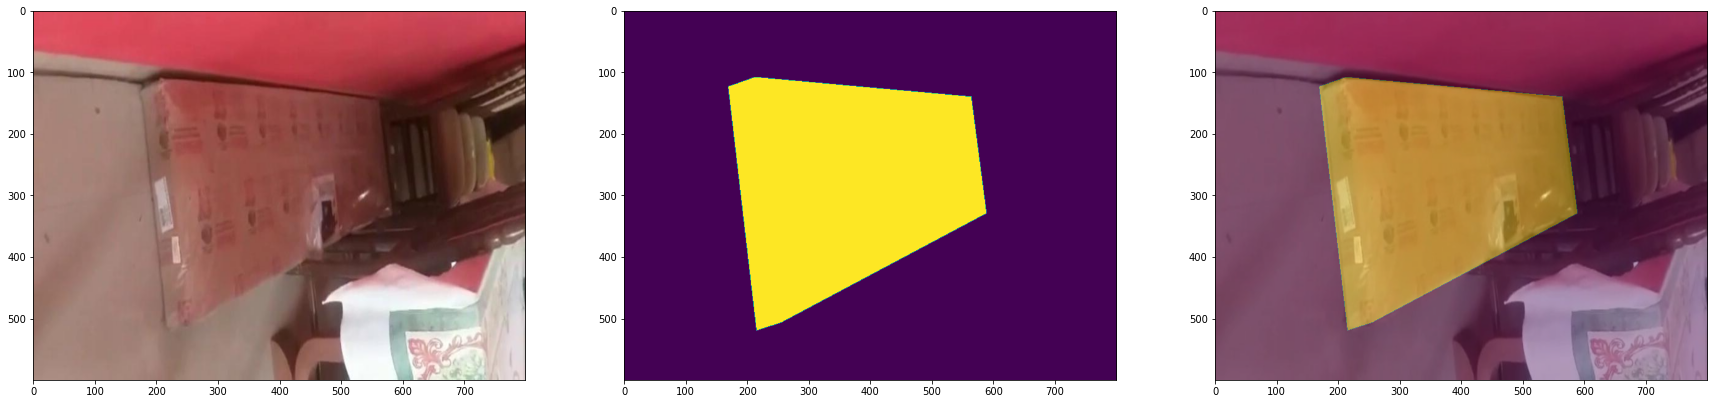

In [8]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [9]:
image.shape

(600, 800, 3)

In [10]:
mask = coco_data.annToMask(anns[0])
mask.shape, image.max()

((600, 800), 255)

In [11]:
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        img_ = coco_data.imgs[image_id_]
        image_path="/content/data/images/cartones/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            labels_train_.append(mask_)
        else:
            img_test_.append(image_path)
            labels_test_.append(mask_)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [12]:
img_train, img_test, labels_train, labels_test = loadImages(coco_data, split=0.1)

In [13]:
labels_train.shape, labels_test.shape, labels_test.min(), labels_test.max()

((941, 600, 800), (104, 600, 800), 0, 2)

In [14]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
      image_load = Image.open(self.X[ix]).convert('RGB')
      image = np.array(image_load)/255
      img = image.astype(np.float32)

      mask = self.y[ix]    
      img = torch.from_numpy(img).permute(2,0,1)
      mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)
      return img, torch.from_numpy(mask).permute(2,0,1)

In [15]:
dataset = {
    'train': Dataset(img_train, labels_train),
    'test': Dataset(img_test, labels_test)
}

len(dataset['train']), len(dataset['test'])

(941, 104)

In [16]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 600, 800]), torch.Size([5, 3, 600, 800]))

In [17]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [18]:
model = UNet()
output = model(torch.randn((5,3,600,800)))
output.shape

torch.Size([5, 3, 600, 800])

In [19]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious)

In [20]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [47]:
model = UNet()

In [50]:

hist = fit(model, dataloader, epochs=1)

test_loss 0.17586 test_iou 0.90688: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Epoch 1/1 loss 0.16622 iou 0.90184 test_loss 0.17586 test_iou 0.90688


In [21]:
hist = fit(model, dataloader, epochs=30)

test_loss 0.31634 test_iou 0.84785: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]



Epoch 1/30 loss 0.42478 iou 0.64767 test_loss 0.31634 test_iou 0.84785


test_loss 0.26599 test_iou 0.86737: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Epoch 2/30 loss 0.29991 iou 0.84817 test_loss 0.26599 test_iou 0.86737


test_loss 0.24060 test_iou 0.87800: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Epoch 3/30 loss 0.27374 iou 0.85305 test_loss 0.24060 test_iou 0.87800


test_loss 0.25418 test_iou 0.87499: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Epoch 4/30 loss 0.25744 iou 0.86046 test_loss 0.25418 test_iou 0.87499


test_loss 0.23015 test_iou 0.88415: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]



Epoch 5/30 loss 0.24874 iou 0.86189 test_loss 0.23015 test_iou 0.88415


test_loss 0.22786 test_iou 0.88344: 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]



Epoch 6/30 loss 0.23383 iou 0.86608 test_loss 0.22786 test_iou 0.88344


test_loss 0.20232 test_iou 0.88603: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]



Epoch 7/30 loss 0.23363 iou 0.86623 test_loss 0.20232 test_iou 0.88603


test_loss 0.22716 test_iou 0.88054: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 8/30 loss 0.22576 iou 0.87158 test_loss 0.22716 test_iou 0.88054


test_loss 0.21884 test_iou 0.88324: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 9/30 loss 0.22187 iou 0.87268 test_loss 0.21884 test_iou 0.88324


test_loss 0.18832 test_iou 0.88963: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 10/30 loss 0.21937 iou 0.87550 test_loss 0.18832 test_iou 0.88963


test_loss 0.26479 test_iou 0.87622: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]



Epoch 11/30 loss 0.21820 iou 0.87662 test_loss 0.26479 test_iou 0.87622


test_loss 0.19306 test_iou 0.88888: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 12/30 loss 0.21227 iou 0.87728 test_loss 0.19306 test_iou 0.88888


test_loss 0.33376 test_iou 0.84199: 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]



Epoch 13/30 loss 0.20991 iou 0.88059 test_loss 0.33376 test_iou 0.84199


test_loss 0.17487 test_iou 0.90606: 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]



Epoch 14/30 loss 0.20801 iou 0.87989 test_loss 0.17487 test_iou 0.90606


test_loss 0.20940 test_iou 0.90192: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 15/30 loss 0.19949 iou 0.88523 test_loss 0.20940 test_iou 0.90192


test_loss 0.18309 test_iou 0.88955: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]



Epoch 16/30 loss 0.20057 iou 0.88502 test_loss 0.18309 test_iou 0.88955


test_loss 0.17059 test_iou 0.90290: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]



Epoch 17/30 loss 0.18700 iou 0.89031 test_loss 0.17059 test_iou 0.90290


test_loss 0.18763 test_iou 0.89898: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 18/30 loss 0.19100 iou 0.88918 test_loss 0.18763 test_iou 0.89898


test_loss 0.18271 test_iou 0.90129: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 19/30 loss 0.18947 iou 0.88881 test_loss 0.18271 test_iou 0.90129


test_loss 0.15771 test_iou 0.91119: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 20/30 loss 0.18331 iou 0.89451 test_loss 0.15771 test_iou 0.91119


test_loss 0.16427 test_iou 0.90777: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 21/30 loss 0.18213 iou 0.89490 test_loss 0.16427 test_iou 0.90777


test_loss 0.21883 test_iou 0.87802: 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]



Epoch 22/30 loss 0.18354 iou 0.89389 test_loss 0.21883 test_iou 0.87802


test_loss 0.15838 test_iou 0.91193: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 23/30 loss 0.18846 iou 0.89069 test_loss 0.15838 test_iou 0.91193


test_loss 0.21274 test_iou 0.88637: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 24/30 loss 0.17977 iou 0.89694 test_loss 0.21274 test_iou 0.88637


test_loss 0.15209 test_iou 0.91032: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]



Epoch 25/30 loss 0.17094 iou 0.90001 test_loss 0.15209 test_iou 0.91032


test_loss 0.15729 test_iou 0.90660: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]



Epoch 26/30 loss 0.17326 iou 0.89908 test_loss 0.15729 test_iou 0.90660


test_loss 0.15499 test_iou 0.91715: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]



Epoch 27/30 loss 0.17765 iou 0.89592 test_loss 0.15499 test_iou 0.91715


test_loss 0.14786 test_iou 0.91229: 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]



Epoch 28/30 loss 0.17135 iou 0.90118 test_loss 0.14786 test_iou 0.91229


test_loss 0.16629 test_iou 0.90980: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]



Epoch 29/30 loss 0.17113 iou 0.90081 test_loss 0.16629 test_iou 0.90980


test_loss 0.17869 test_iou 0.91091: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


Epoch 30/30 loss 0.16897 iou 0.90346 test_loss 0.17869 test_iou 0.91091


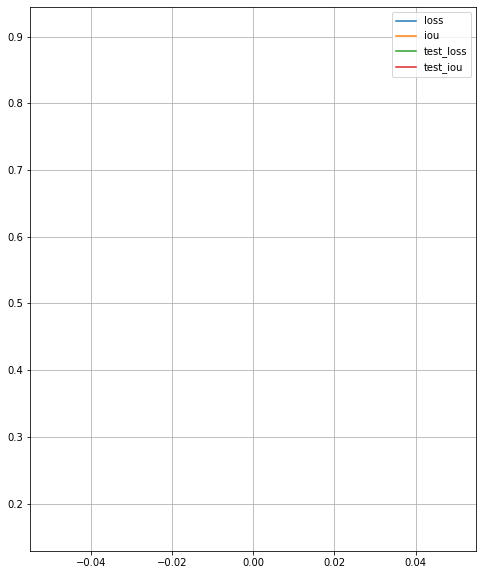

In [51]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [34]:
path = 'saved_weights_segmentation.pt'

In [24]:
torch.save(model.state_dict(), 'saved_weights_segmentation.pt')


In [49]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [54]:
image_load_1 = Image.open('/content/carton_1.png').convert('RGB')
image_1 = np.array(image_load_1)/255
img_1 = image_1.astype(np.float32)
img_1 = torch.from_numpy(img_1).permute(2,0,1)

image_load_2 = Image.open('/content/carton_2.png').convert('RGB')
image_2 = np.array(image_load_2)/255
img_2 = image_2.astype(np.float32)
img_2 = torch.from_numpy(img_2).permute(2,0,1)

image_load_3 = Image.open('/content/carton_3.png').convert('RGB')
image_3 = np.array(image_load_3)/255
img_3 = image_3.astype(np.float32)
img_3 = torch.from_numpy(img_3).permute(2,0,1)


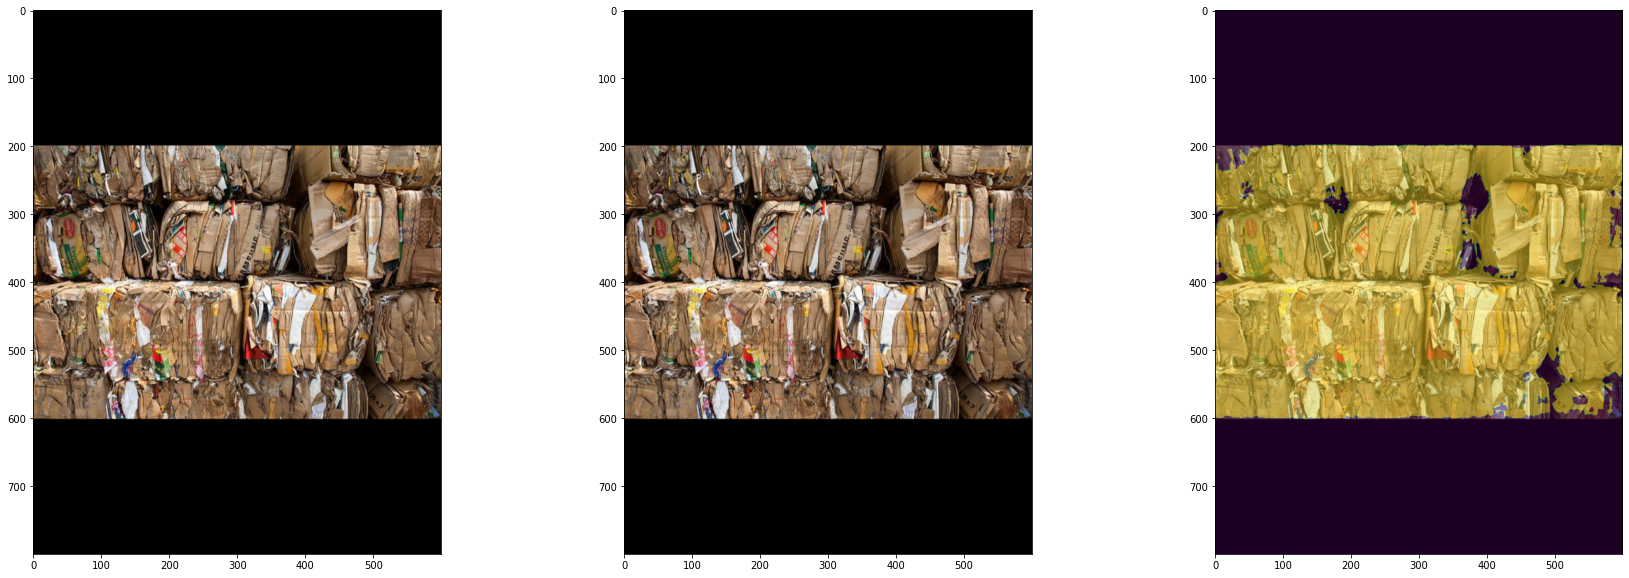

In [58]:
model.eval()
with torch.no_grad():
    output = model(img_3.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img_3.squeeze(0).permute(1,2,0))
ax2.imshow(image_3)

ax3.imshow(img_3.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)

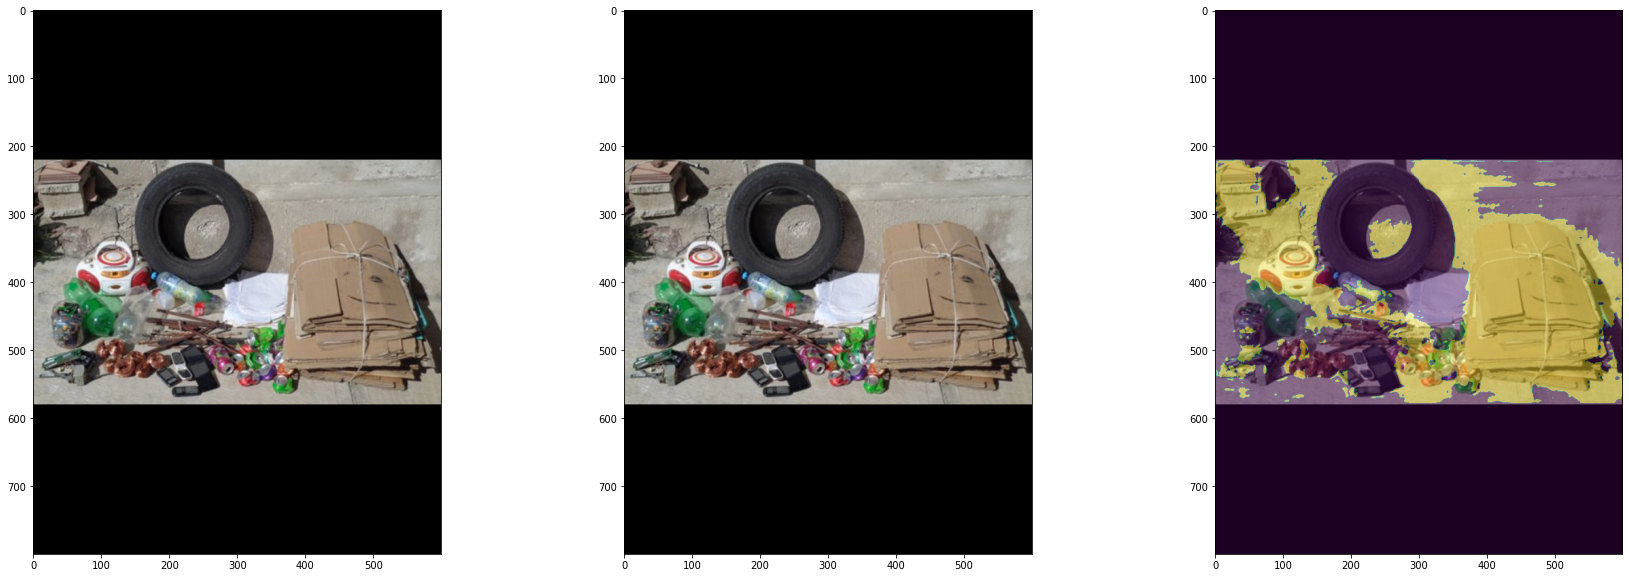

In [57]:
model.eval()
with torch.no_grad():
    output = model(img_2.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img_2.squeeze(0).permute(1,2,0))
ax2.imshow(image_2)

ax3.imshow(img_2.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)


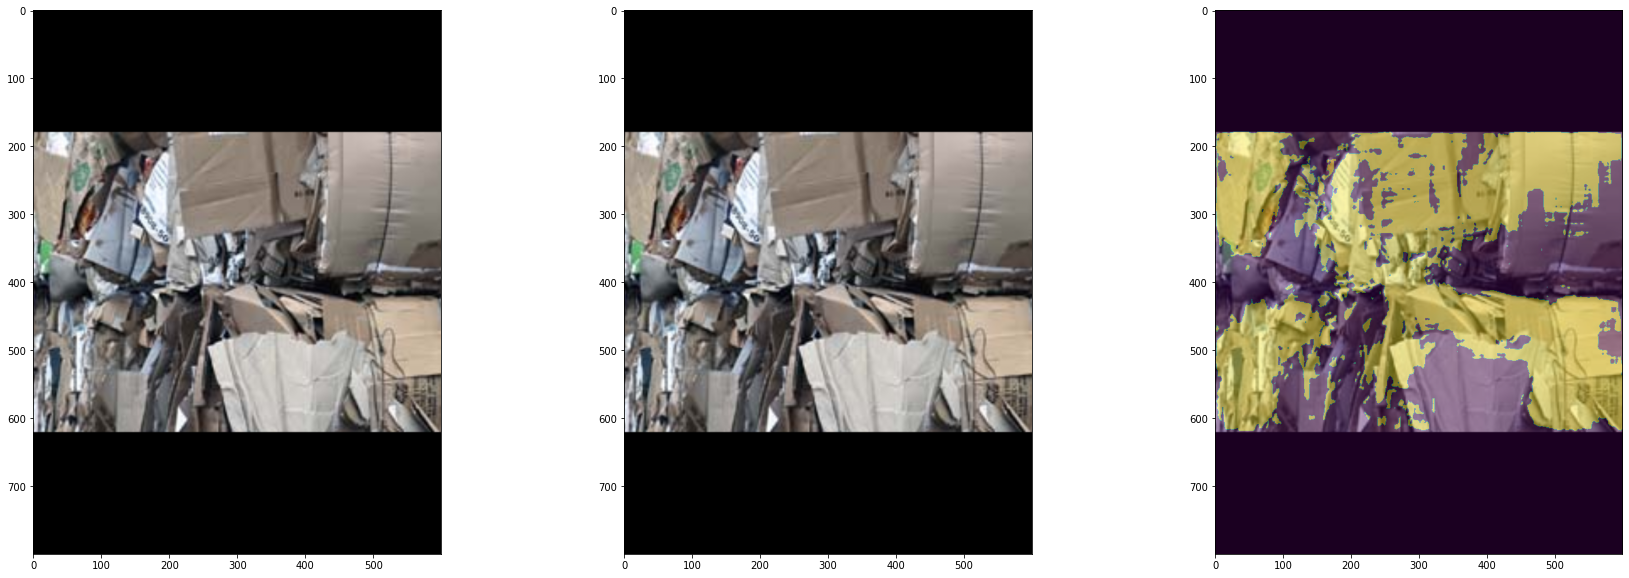

In [59]:
model.eval()
with torch.no_grad():
    output = model(img_1.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img_1.squeeze(0).permute(1,2,0))
ax2.imshow(image_1)

ax3.imshow(img_1.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)